<a href="https://colab.research.google.com/github/gongx030/seatac_manuscript/blob/main/notebooks/pred_histone_bs640_k10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate V-plot representations of GM12878, K562, and Etv2 reprogramming data

## Background

Reviewer #1's Issue #2: Further, as SeATAC appears to be unique in documenting decreased chromatin accessibility at promoters of regulated genes, this aspect would be particularly interesting to biologists and browser views would be very helpful to convince the readers. To be really helpful, these browser views should include other typical marks of promoters and enhancers such as H3K4me3, H3K4me1, H3K27ac, etc.

## Tasks

* Train SeATAC model on GM12878, K562 and Etv2 reprogramming ATAC-seq
* Get V-plot representations
* Get PCA representations of MACS2 and NucleoATAC signals
* Train a simple MLP model to predict histone codes (H3K4me1, H3K4me3, H3K27ac, H3K27me3 and etc.) from V-plots representations.
* Evaluate the prediction performance.
* Verify the prediction of H3K27ac on Etv2 reprogramming data.
* Predict the missing histone codes for the Etv2 binding sites in Etv2 reprogramming data.

## Setup

### MSI Parition

```salloc --nodes=1 --ntasks-per-node=16 --mem=64gb -t 24:00:00 -p interactive```

### Conda

```r421_py37_tf26```

### Install R packages

In [ ]:
required_packages <- c(
  'BiocManager', 'devtools', 'Matrix',
  'dplyr', 'tidyr', 'stringr',
  'pROC', 'irlba',
  'chromVAR', 'chromVARmotifs', 'motifmatchr'
)

In [ ]:
missing_packages <- required_packages[!required_packages %in% rownames(installed.packages())]
if (length(missing_packages) > 0){
    BiocManager::install(missing_packages)
}

In [ ]:
for (p in required_packages){
  library(p, character.only  = TRUE)
}

Bioconductor version '3.15' is out-of-date; the current release version '3.16'
  is available with R version '4.2'; see https://bioconductor.org/install

Loading required package: usethis


Attaching package: ‘devtools’


The following object is masked from ‘package:BiocManager’:

    install


Warning message:
“package ‘Matrix’ was built under R version 4.2.2”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack


Warning message:
“package ‘stringr’ was built under R version 4.2.2”
Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var






### Install SeATAC from github

In [ ]:
#devtools::install('../seatac')
#install_github('gongx030/seatac@v0.4.0', force = TRUE, quiet = FALSE)

In [ ]:
#reload(pkgload::inst("seatac"))
#library(seatac)

In [ ]:
devtools::load_all('../seatac')

ℹ Loading seatac
Loading required package: tensorflow

Warning message:
“package ‘tensorflow’ was built under R version 4.2.2”
Loading required package: tfprobability

Loading required package: tfdatasets

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:pROC’:

    var


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tappl

### Load `tfa`

Required for `tfa.image.gaussian_filter2d`

In [ ]:
tfa <- reticulate::import('tensorflow_addons')

### Load bpt

In [ ]:
devtools::load_all('../bpt')

ℹ Loading bpt
Warning message:
“replacing previous import ‘GenomicRanges::union’ by ‘dplyr::union’ when loading ‘bpt’”
Warning message:
“replacing previous import ‘GenomicRanges::intersect’ by ‘dplyr::intersect’ when loading ‘bpt’”
Warning message:
“replacing previous import ‘GenomicRanges::setdiff’ by ‘dplyr::setdiff’ when loading ‘bpt’”


## Parameters

In [ ]:
set.seed(123)

In [ ]:
ARGS <- list(

  remote_bam_files = c(
    'GM12878' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells.bam',
    'K562' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=K562_version=20230104a/K562.bam',
    'MEF_NoDox' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_NoDox.bam',
    'MEF_Dox_D7_Flk1pos' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_Flk1pos.bam',
    'EB_NoDox_D25' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_NoDox_D25.bam',
    'EB_Dox_D25_Flk1pos' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_Dox_D25_Flk1pos.bam'
  ), 
  genome_versions = c('hg19', 'hg19', 'mm10', 'mm10', 'mm10', 'mm10'),
  remote_bw_files = list(
    'GM12878' = c(
      'H3K27ac' = 'https://www.encodeproject.org/files/ENCFF440GZA/@@download/ENCFF440GZA.bigWig',
      'H3K4me1' = 'https://www.encodeproject.org/files/ENCFF372EXQ/@@download/ENCFF372EXQ.bigWig',
      'H3K4me3' = 'https://www.encodeproject.org/files/ENCFF154XCY/@@download/ENCFF154XCY.bigWig'
    ),
    'K562' = c(
      'H3K27ac' = 'https://www.encodeproject.org/files/ENCFF488FYZ/@@download/ENCFF488FYZ.bigWig',
      'H3K4me1' = 'https://www.encodeproject.org/files/ENCFF700ZWZ/@@download/ENCFF700ZWZ.bigWig',
      'H3K4me3' = 'https://www.encodeproject.org/files/ENCFF285EUA/@@download/ENCFF285EUA.bigWig'
    ),
    'MEF_NoDox' = c(
      'H3K27ac' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_NoDox_d0_H3K27ac_FE.bw'
    ),
    'MEF_Dox_D7_Flk1pos' = c(
      'H3K27ac' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d7_H3K27ac_FE.bw'
    ),
    'EB_NoDox_D25' = c(
      'H3K27ac' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_NoDox_12h_H3K27ac_FE.bw'
    ),
    'EB_Dox_D25_Flk1pos' = c(
      'H3K27ac' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_Dox_12h_H3K27ac_FE.bw'
    )
  ),
  block_size = 640L,
  latent_dim = 10L,
  min_reads_train_seatac = 5L,  # minimum reads in blocks to train SeATAC
  min_reads_train_histone = 5L,  # minimum reads in blocks to train histone model
  min_reads_test_histone = 5L, # minimum reads in blocks to test histone model
  step_size = 200L,
  fragment_size_range_max = 640L,
  bin_size = 5L,
  fragment_size_interval = 10L,
  window_size = 2000L,
  sliding_step = 10L,
  max_peaks_train_seatac = 2000L, # maximum peaks per sample for training SeATAC
  max_peaks_count_reads = 10000L,  # maximum peaks for counting reads
  max_peaks_train_histone = 50000L, # maximum peaks for training histone model
  max_peaks_test_histone = 20000L, # maximum peaks for testing histone model
  batch_size = 256L,
  epochs = 100L,
  validation_split = 0.2,
  dataset_train_histone = c('GM12878'),
  min_histone_signal_train = 100,
  min_histone_signal_test = 10,

  remote_representation_file = 'https://s3.msi.umn.edu/gongx030/projects/seatac_project/etv2_20230108a.RData'

)

In [ ]:
ARGS$local_bam_files <- gsub('https://', './', ARGS$remote_bam_files)

In [ ]:
ARGS$remote_summit_files <- gsub('.bam', '_summits.bed', ARGS$remote_bam_files)
ARGS$local_summit_files <- gsub('https://', './', ARGS$remote_summit_files)

In [ ]:
ARGS$local_bw_files <- list()
for (i in names(ARGS$remote_bw_files)){
  for (j in names(ARGS$remote_bw_files[[i]])){
    ARGS$local_bw_files[[i]][j] <- gsub('https://', './', ARGS$remote_bw_files[[i]][j])
  }
  stopifnot(all(file.exists(ARGS$local_bw_files[[i]])))
}

In [ ]:
ARGS$remote_nucleoatac_files <- gsub('.bam', '.nucleoatac_signal.smooth.bw', ARGS$remote_bam_files)
ARGS$local_nucleoatac_files <- gsub('https://', './', ARGS$remote_nucleoatac_files)

In [ ]:
ARGS$remote_macs2_files <- gsub('.bam', '_treat_pileup.bw', ARGS$remote_bam_files)
ARGS$local_macs2_files <- gsub('https://', './', ARGS$remote_macs2_files)

In [ ]:
ARGS$local_representation_file <- gsub('https://', './', ARGS$remote_representation_file)
ARGS$s3_representation_file <- gsub('https://s3.msi.umn.edu/', 's3://', ARGS$remote_representation_file)

## Download files

### BAM files

In [ ]:
download_remote_file(ARGS$remote_bam_files)

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells.bam

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=K562_version=20230104a/K562.bam

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_NoDox.bam

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_Flk1pos.bam

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_NoDox_D25.bam

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_Dox_D25_Flk1pos.bam



In [ ]:
stopifnot(all(file.exists(ARGS$local_bam_files)))

### Summit files

In [ ]:
download_remote_file(ARGS$remote_summit_files)

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells_summits.bed

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=K562_version=20230104a/K562_summits.bed

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_NoDox_summits.bed

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_Flk1pos_summits.bed

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_NoDox_D25_summits.bed

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_Dox_D25_Flk1pos_summits.bed



In [ ]:
stopifnot(file.exists(ARGS$local_summit_files))

### bigwig files

In [ ]:
for (i in names(ARGS$remote_bw_files)){
  download_remote_file(ARGS$remote_bw_files[[i]])
  stopifnot(all(file.exists(ARGS$local_bw_files[[i]])))
}

wget -cx https://www.encodeproject.org/files/ENCFF440GZA/@@download/ENCFF440GZA.bigWig

wget -cx https://www.encodeproject.org/files/ENCFF372EXQ/@@download/ENCFF372EXQ.bigWig

wget -cx https://www.encodeproject.org/files/ENCFF154XCY/@@download/ENCFF154XCY.bigWig

wget -cx https://www.encodeproject.org/files/ENCFF488FYZ/@@download/ENCFF488FYZ.bigWig

wget -cx https://www.encodeproject.org/files/ENCFF700ZWZ/@@download/ENCFF700ZWZ.bigWig

wget -cx https://www.encodeproject.org/files/ENCFF285EUA/@@download/ENCFF285EUA.bigWig

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_NoDox_d0_H3K27ac_FE.bw

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d7_H3K27ac_FE.bw

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_NoDox_12h_H3K27ac_FE.bw

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_Dox_12h

### NucleoATAC files

In [ ]:
download_remote_file(ARGS$remote_nucleoatac_files)

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells.nucleoatac_signal.smooth.bw

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=K562_version=20230104a/K562.nucleoatac_signal.smooth.bw

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_NoDox.nucleoatac_signal.smooth.bw

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_Flk1pos.nucleoatac_signal.smooth.bw

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_NoDox_D25.nucleoatac_signal.smooth.bw

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_Dox_D25_Flk1pos.nucleoatac_signal.smooth.bw



In [ ]:
stopifnot(all(file.exists(ARGS$local_nucleoatac_files)))

### MACS2 pileup files

In [ ]:
download_remote_file(ARGS$remote_macs2_files)

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells_treat_pileup.bw

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=K562_version=20230104a/K562_treat_pileup.bw

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_NoDox_treat_pileup.bw

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_Flk1pos_treat_pileup.bw

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_NoDox_D25_treat_pileup.bw

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_Dox_D25_Flk1pos_treat_pileup.bw



In [ ]:
stopifnot(all(file.exists(ARGS$local_macs2_files)))

## Read summits for training SeATAC

In [ ]:
x <- list()
for (i in 1:length(ARGS$local_bam_files)){
  sprintf('reading %s', ARGS$local_summit_files[i]) %>% message()
  gr0 <- read.table(ARGS$local_summit_files[i], header = FALSE, sep = '\t')
  gr0 <- GRanges(seqnames = gr0[, 1], range = IRanges(start = gr0[, 2], end = gr0[, 3]))
  gr0 <- gr0[seqnames(gr0) %in% sprintf('chr%s', c(1:22, 'X'))]
  gr0 <- resize(gr0, fix = 'center', width = ARGS$window_size)

  gr <- slidingWindows(gr0, width = ARGS$block_size, step = ARGS$bin_size) %>% unlist()
  sprintf('total blocks: %d', length(gr)) %>% message()
  gr <- sample(gr, min(length(gr), ARGS$max_peaks_count_reads))
  sprintf('total blocks for training: %d', length(gr)) %>% message()

  counts <- count_reads(gr, ARGS$local_bam_files[i], genome = get_bsgenome(ARGS$genome_versions[i]),  fragment_size_range = c(0, ARGS$fragment_size_range_max))

  valid <- counts >= ARGS$min_reads_train_seatac
  sprintf('number of valid peaks for VaeModel(>=%d reads): %d', ARGS$min_reads_train_seatac, sum(valid)) %>% message()

  gr <- gr[valid]
  gr <- sample(gr, min(length(gr), ARGS$max_peaks_train_seatac))
  sprintf('sampling %d valid peaks for training VaeModel', length(gr)) %>% message()

  x[[i]] <- read_vplot(
    gr,
    filenames = ARGS$local_bam_files[i], 
    genome = get_bsgenome(ARGS$genome_versions[i]),
    bin_size = ARGS$bin_size,
    fragment_size_range = c(0, ARGS$fragment_size_range_max),
    fragment_size_interval = ARGS$fragment_size_interval 
  )
}

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells_summits.bed

total blocks: 28502565

total blocks for training: 10000

Loading required package: BSgenome.Mmusculus.UCSC.mm10

Loading required package: BSgenome

Loading required package: Biostrings

Loading required package: XVector


Attaching package: ‘Biostrings’


The following object is masked from ‘package:base’:

    strsplit


Loading required package: rtracklayer

Loading required package: BSgenome.Hsapiens.UCSC.hg19

read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells.bam

number of valid peaks for VaeModel(>=5 reads): 9978

Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”
sampling 2000 valid peaks for training VaeModel

read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells.ba

In [ ]:
names(x) <- names(ARGS$local_bam_files)
x <- VplotsList(x)

## Training SeATAC

In [ ]:
model <- VaeModel(x, latent_dim = ARGS$latent_dim)

In [ ]:
model <- model %>% fit(x, batch_size = ARGS$batch_size, epochs = ARGS$epochs, compile = TRUE)

epoch=     1/   100 | beta=1.000e+00 | loss= 6128.3309820 | loss_reconstruction= 6125.6838015 | loss_kl=    2.6471532

epoch=     2/   100 | beta=1.000e+00 | loss= 4062.7965166 | loss_reconstruction= 4061.0384444 | loss_kl=    1.7580885

epoch=     3/   100 | beta=1.000e+00 | loss= 1676.7342711 | loss_reconstruction= 1676.4609245 | loss_kl=    0.2733526

epoch=     4/   100 | beta=1.000e+00 | loss=  549.2022004 | loss_reconstruction=  549.0192540 | loss_kl=    0.1829454

epoch=     5/   100 | beta=1.000e+00 | loss=  375.0864005 | loss_reconstruction=  373.8919106 | loss_kl=    1.1944921

epoch=     6/   100 | beta=1.000e+00 | loss=  337.0319805 | loss_reconstruction=  334.8865837 | loss_kl=    2.1453968

epoch=     7/   100 | beta=1.000e+00 | loss=  325.4783419 | loss_reconstruction=  322.0617731 | loss_kl=    3.4165678

epoch=     8/   100 | beta=1.000e+00 | loss=  321.1480596 | loss_reconstruction=  317.4270020 | loss_kl=    3.7210572

epoch=     9/   100 | beta=1.000e+00 | loss=  31

## Etv2 motifs in Etv2 pioneer data

In [ ]:
gr0 <- lapply(ARGS$local_summit_files[c('MEF_NoDox','MEF_Dox_D7_Flk1pos','EB_NoDox_D25','EB_Dox_D25_Flk1pos')], function(bed_file){
  peaks <- read.table(bed_file, header = FALSE, sep = '\t')
  peaks <- GRanges(seqnames = peaks[, 1], range = IRanges(start = peaks[, 2], end = peaks[, 3]))
  peaks <- resize(peaks, fix = 'center', width = ARGS[['step_size']])
  peaks
}) %>%
  GRangesList() %>%
  coverage() %>%
  IRanges::slice(lower = 1, rangesOnly = TRUE) %>%
  GRanges() %>%
  resize(fix = 'center', width = 800L)
gr0 <- gr0[seqnames(gr0) %in% sprintf('chr%s', c(1:22, 'X'))]   

In [ ]:
data('homer_pwms')

In [ ]:
j <- 82 # Etv2
homer_pwms[j]

PWMatrixList of length 1
names(1): Etv2(ETS)/ES-ER71-ChIP-Seq(GSE59402)/Homer(0.967)

In [ ]:
gr_etv2 <- matchMotifs(homer_pwms[j], gr0, genome = BSgenome.Mmusculus.UCSC.mm10, out = 'positions')[[1]] %>%
  resize(width = ARGS$block_size, fix = 'center')

In [ ]:
sprintf('number of motif-centric regions: %s', length(gr_etv2)) %>% message()

number of motif-centric regions: 32222



## Read summits for histone model



In [ ]:
x <- list()

In [ ]:
for (i in 1:length(ARGS$local_bam_files)){
  sprintf('reading %s', ARGS$local_summit_files[i]) %>% message()

  if (names(ARGS$local_bam_files)[i] %in% c('MEF_NoDox','MEF_Dox_D7_Flk1pos','EB_NoDox_D25','EB_Dox_D25_Flk1pos')){
    gr <- gr_etv2
  }else{
    gr0 <- read.table(ARGS$local_summit_files[i], header = FALSE, sep = '\t')
    gr0 <- GRanges(seqnames = gr0[, 1], range = IRanges(start = gr0[, 2], end = gr0[, 3]))
    gr0 <- gr0[seqnames(gr0) %in% sprintf('chr%s', c(1:22, 'X'))]
    gr0 <- resize(gr0, fix = 'center', width = ARGS$window_size)

    gr <- slidingWindows(gr0, width = ARGS$block_size, step = ARGS$bin_size) %>% unlist()
  
    if (names(ARGS$local_bam_files)[i] %in% c(ARGS$dataset_train_histone)){ # data for training histone marks
      gr <- sample(gr, min(length(gr), ARGS$max_peaks_train_histone))
      counts <- count_reads(gr, ARGS$local_bam_files[i], genome = get_bsgenome(ARGS$genome_versions[i]),  fragment_size_range = c(0, ARGS$fragment_size_range_max))
      valid <- counts >= ARGS$min_reads_train_histone
    }else{ # data for testing histone marks
      gr <- sample(gr, min(length(gr), ARGS$max_peaks_test_histone))
      counts <- count_reads(gr, ARGS$local_bam_files[i], genome = get_bsgenome(ARGS$genome_versions[i]),  fragment_size_range = c(0, ARGS$fragment_size_range_max))
      valid <- counts >= ARGS$min_reads_test_histone
    }
    gr <- gr[valid]
  }

  sprintf('total blocks for %s: %d', names(ARGS$local_bam_files)[i], length(gr)) %>% message()

  x[[i]] <- read_vplot(
    gr,
    filenames = ARGS$local_bam_files[i], 
    genome = get_bsgenome(ARGS$genome_versions[i]),
    bin_size = ARGS$bin_size,
    fragment_size_range = c(0, ARGS$fragment_size_range_max),
    fragment_size_interval = ARGS$fragment_size_interval 
  )
}

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells_summits.bed

read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells.bam

Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”
total blocks for GM12878: 49911

read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells.bam

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=K562_version=20230104a/K562_summits.bed

read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=K562_version=20230104a/K562.bam

Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”
total blocks for K562: 19965

read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=K562_version=20230104a/K562.bam

reading ./s3.msi.umn.edu/gongx03

In [ ]:
names(x) <- names(ARGS$local_bam_files)
x <- VplotsList(x)

## Get inputs for histone models

The inputs for predicting histone marks. For SeATC, the inputs are the latent representation. For MACS2 and NucleoATAC, the inputs are the PCA of the corresonding scaled signals.

### SeATAC

In [ ]:
x <- model %>% seatac::predict(x, batch_size = ARGS$batch_size, vplots = FALSE)

### MACS2

In [ ]:
for (i in 1:length(ARGS$local_macs2_files)){
  sprintf('reading %s', ARGS$local_macs2_files[i]) %>% message()
  cvg <- rtracklayer::import(ARGS$local_macs2_files[i], which = rowRanges(x[[i]]))
  seqlengths(cvg) <- seqlengths(cvg) + ARGS$block_size
  cvg <- coverage(cvg, weight = 'score')
  y <- cvg[rowRanges(x[[i]])] %>% as.matrix()
  y <- (y - rowMins(y)) / (rowMaxs(y) - rowMins(y))
  y[is.na(y) | is.infinite(y)] <- 0
  rowData(x[[i]])$macs2 <- y
}

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells_treat_pileup.bw

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=K562_version=20230104a/K562_treat_pileup.bw

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_NoDox_treat_pileup.bw

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_Flk1pos_treat_pileup.bw

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_NoDox_D25_treat_pileup.bw

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_Dox_D25_Flk1pos_treat_pileup.bw



In [ ]:
u <- NULL
gs <- NULL
for (i in 1:length(ARGS$local_macs2_files)){
  u <- rbind(u, rowData(x[[i]])$macs2)
  gs <- c(gs, rep(i, nrow(rowData(x[[i]]))))
}
u <- prcomp_irlba(u, n = ARGS$latent_dim)$x
h <- split(1:nrow(u), factor(gs))

In [ ]:
for (i in 1:length(ARGS$local_macs2_files)){
  rowData(x[[i]])$macs2_pca <- u[h[[i]], ]
}

### NucleoATAC

In [ ]:
for (i in 1:length(ARGS$local_nucleoatac_files)){
  sprintf('reading %s', ARGS$local_nucleoatac_files[i]) %>% message()
  cvg <- rtracklayer::import(ARGS$local_nucleoatac_files[i], which = rowRanges(x[[i]]))
  seqlengths(cvg) <- seqlengths(cvg) + ARGS$block_size
  cvg <- coverage(cvg, weight = 'score')
  y <- cvg[rowRanges(x[[i]])] %>% as.matrix()
  y <- (y - rowMins(y)) / (rowMaxs(y) - rowMins(y))
  y[is.na(y) | is.infinite(y)] <- 0
  rowData(x[[i]])$nucleoatac <- y
}

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells.nucleoatac_signal.smooth.bw

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=K562_version=20230104a/K562.nucleoatac_signal.smooth.bw

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_NoDox.nucleoatac_signal.smooth.bw

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_Flk1pos.nucleoatac_signal.smooth.bw

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_NoDox_D25.nucleoatac_signal.smooth.bw

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_Dox_D25_Flk1pos.nucleoatac_signal.smooth.bw



In [ ]:
u <- NULL
gs <- NULL
for (i in 1:length(ARGS$local_nucleoatac_files)){
  u <- rbind(u, rowData(x[[i]])$nucleoatac)
  gs <- c(gs, rep(i, nrow(rowData(x[[i]]))))
}
u <- prcomp_irlba(u, n = ARGS$latent_dim)$x
h <- split(1:nrow(u), factor(gs))

In [ ]:
for (i in 1:length(ARGS$local_nucleoatac_files)){
  rowData(x[[i]])$nucleoatac_pca <- u[h[[i]], ]
}

## Reading training histone data

In [ ]:
y_train <- NULL
for (i in ARGS$dataset_train_histone){
  y <- NULL
  for (j in c('H3K27ac', 'H3K4me1', 'H3K4me3')){
    sprintf('reading %s', ARGS$local_bw_files[[i]][j]) %>% message()
    cvg <- rtracklayer::import(ARGS$local_bw_files[[i]][j], which = rowRanges(x[[i]]))
    seqlengths(cvg) <- seqlengths(cvg) + ARGS$block_size
    cvg <- coverage(cvg, weight = 'score')
    yij <- cvg[rowRanges(x[[i]])] %>% as.matrix()
    y <- c(y, yij %>% tf$cast(tf$float32) %>% tf$expand_dims(2L))
  }
  y <- tf$concat(y, axis = 2L)
  y_train <- c(y_train, y)
}

reading ./www.encodeproject.org/files/ENCFF440GZA/@@download/ENCFF440GZA.bigWig

reading ./www.encodeproject.org/files/ENCFF372EXQ/@@download/ENCFF372EXQ.bigWig

reading ./www.encodeproject.org/files/ENCFF154XCY/@@download/ENCFF154XCY.bigWig



In [ ]:
y_train <- tf$concat(y_train, axis = 0L)
y_train <- tfa$image$gaussian_filter2d(y_train, filter_shape = shape(1L, 20L), sigma = 1.0, padding = 'REFLECT')

include_train_histone <- tf$reduce_sum(tf$cast(tf$reduce_sum(y_train, shape(1L)) > ARGS$min_histone_signal_train, tf$float32), axis = 1L) == 3L

y_train <- (y_train - tf$reduce_min(y_train, axis = 1L, keepdims = TRUE)) / (tf$reduce_max(y_train, axis = 1L, keepdims = TRUE) - tf$reduce_min(y_train, axis = 1L, keepdims = TRUE))
is_nan <- tf$math$is_nan(y_train)
y_train <- tf$where(is_nan, tf$zeros_like(is_nan, dtype = tf$float32), y_train)
y_train <- tf$boolean_mask(y_train, include_train_histone)

In [ ]:
table(as.numeric(include_train_histone))


    0     1 
14546 35365 

## Fitting histone model

In [ ]:
df_losses <- NULL

### MACS2

#### Training on GM12878

In [ ]:
x_train <- NULL
for (i in ARGS$dataset_train_histone){
  x_train <- c(x_train, tf$cast(rowData(x[[i]])$macs2_pca, tf$float32))
}
x_train <- tf$concat(x_train, axis = 0L)
x_train <- tf$boolean_mask(x_train, include_train_histone)

In [ ]:
tf$keras$backend$clear_session()

model_histone <- keras_model_sequential(input_shape = c(ARGS$latent_dim)) %>%
  layer_dense(128L, activation = "relu") %>%
  layer_dropout(0.1) %>%
  layer_dense(256L, activation = "relu") %>%
  layer_dropout(0.1) %>%
  layer_dense(512L, activation = "relu") %>%
  layer_dropout(0.1) %>%
  layer_dense(ARGS$block_size * 3L, activation = "sigmoid") %>%
  layer_reshape(c(ARGS$block_size, 3L)) 

model_histone %>% compile(
  optimizer = "adam",
  loss = 'mse'
)

history <- model_histone %>% keras::fit(
  x_train, 
  y_train,
  epochs = 50L, 
  batch_size = ARGS$batch_size, 
  validation_split = 0.2,
  callbacks = tf$keras$callbacks$EarlyStopping(monitor='val_loss', patience=5)
)

history


Final epoch (plot to see history):
    loss: 0.09515
val_loss: 0.09617 

#### Evaluation

In [ ]:
for (i in which(!names(ARGS$remote_bam_files) %in% ARGS$dataset_train_histone)){

  x_test <- rowData(x[[i]])$macs2_pca %>% tf$cast(tf$float32)

  y_test <- NULL
  for (j in 1:3){ # H3K27ac, H3K4me1, H3K4me3
    if (!is.na(ARGS$local_bw_files[[i]][j])){
      sprintf('reading %s', ARGS$local_bw_files[[i]][j]) %>% message()
      cvg <- rtracklayer::import(ARGS$local_bw_files[[i]][j], which = rowRanges(x[[i]]))
      seqlengths(cvg) <- seqlengths(cvg) + ARGS$block_size
      cvg <- coverage(cvg, weight = 'score')
      y_test <- cvg[rowRanges(x[[i]])] %>% as.matrix()
      y_test <- tf$cast(y_test, tf$float32)
      y_test <- tfa$image$gaussian_filter2d(y_test, filter_shape = shape(1L, 20L), sigma = 1.0, padding = 'REFLECT')

      include <- tf$reduce_sum(tf$cast(y_test > ARGS$min_histone_signal_test, tf$float32), axis = c(1L)) > 0
      sprintf('%d/%d', sum(as.numeric(include)), length(as.numeric(include))) %>% message()

      y_test <- (y_test - tf$reduce_min(y_test, axis = 1L, keepdims = TRUE)) / (tf$reduce_max(y_test, axis = 1L, keepdims = TRUE) - tf$reduce_min(y_test, axis = 1L, keepdims = TRUE))
      is_nan <- tf$math$is_nan(y_test)
      y_test <- tf$where(is_nan, tf$zeros_like(is_nan, dtype = tf$float32), y_test)
      y_pred <- model_histone(x_test)[, , j] 
      df2 <- data.frame(
        method = 'macs2',
        dataset = names(ARGS$remote_bam_files)[i],
        type = names(ARGS$local_bw_files[[i]][j]),
        loss = tf$keras$metrics$mse(tf$boolean_mask(y_test, include), tf$boolean_mask(y_pred, include)) %>% tf$reduce_mean() %>% as.numeric()
      )
      print(df2)
      df_losses <- rbind(df_losses, df2)
    }
  }
}

reading ./www.encodeproject.org/files/ENCFF488FYZ/@@download/ENCFF488FYZ.bigWig

2209/19965



  method dataset    type       loss
1  macs2    K562 H3K27ac 0.08625094


reading ./www.encodeproject.org/files/ENCFF700ZWZ/@@download/ENCFF700ZWZ.bigWig

1225/19965



  method dataset    type       loss
1  macs2    K562 H3K4me1 0.07906256


reading ./www.encodeproject.org/files/ENCFF285EUA/@@download/ENCFF285EUA.bigWig

2722/19965



  method dataset    type      loss
1  macs2    K562 H3K4me3 0.1054259


reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_NoDox_d0_H3K27ac_FE.bw

5343/32222



  method   dataset    type       loss
1  macs2 MEF_NoDox H3K27ac 0.08403791


reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d7_H3K27ac_FE.bw

7858/32222



  method            dataset    type       loss
1  macs2 MEF_Dox_D7_Flk1pos H3K27ac 0.08560304


reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_NoDox_12h_H3K27ac_FE.bw

1201/32222



  method      dataset    type       loss
1  macs2 EB_NoDox_D25 H3K27ac 0.08401173


reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_Dox_12h_H3K27ac_FE.bw

3982/32222



  method            dataset    type      loss
1  macs2 EB_Dox_D25_Flk1pos H3K27ac 0.1011173


### NucleoATAC

#### Training

In [ ]:
x_train <- NULL
for (i in ARGS$dataset_train_histone){
  x_train <- c(x_train, tf$cast(rowData(x[[i]])$nucleoatac_pca, tf$float32))
}
x_train <- tf$concat(x_train, axis = 0L)
x_train <- tf$boolean_mask(x_train, include_train_histone)

In [ ]:
tf$keras$backend$clear_session()

model_histone <- keras_model_sequential(input_shape = c(ARGS$latent_dim)) %>%
  layer_dense(128L, activation = "relu") %>%
  layer_dropout(0.1) %>%
  layer_dense(256L, activation = "relu") %>%
  layer_dropout(0.1) %>%
  layer_dense(512L, activation = "relu") %>%
  layer_dropout(0.1) %>%
  layer_dense(ARGS$block_size * 3L, activation = "sigmoid") %>%
  layer_reshape(c(ARGS$block_size, 3L)) 

model_histone %>% compile(
  optimizer = "adam",
  loss = 'mse'
)

history <- model_histone %>% keras::fit(
  x_train, 
  y_train,
  epochs = 50L, 
  batch_size = ARGS$batch_size, 
  validation_split = 0.2,
  callbacks = tf$keras$callbacks$EarlyStopping(monitor='val_loss', patience=5)
)

history


Final epoch (plot to see history):
    loss: 0.09688
val_loss: 0.09798 

#### Evaluation

In [ ]:
for (i in which(!names(ARGS$remote_bam_files) %in% ARGS$dataset_train_histone)){

  x_test <- rowData(x[[i]])$nucleoatac_pca %>% tf$cast(tf$float32)

  y_test <- NULL
  for (j in 1:3){ # H3K27ac, H3K4me1, H3K4me3
    if (!is.na(ARGS$local_bw_files[[i]][j])){
      sprintf('reading %s', ARGS$local_bw_files[[i]][j]) %>% message()
      cvg <- rtracklayer::import(ARGS$local_bw_files[[i]][j], which = rowRanges(x[[i]]))
      seqlengths(cvg) <- seqlengths(cvg) + ARGS$block_size
      cvg <- coverage(cvg, weight = 'score')
      y_test <- cvg[rowRanges(x[[i]])] %>% as.matrix()
      y_test <- tf$cast(y_test, tf$float32)
      y_test <- tfa$image$gaussian_filter2d(y_test, filter_shape = shape(1L, 20L), sigma = 1.0, padding = 'REFLECT')

      include <- tf$reduce_sum(tf$cast(y_test > ARGS$min_histone_signal_test, tf$float32), axis = c(1L)) > 0
      sprintf('%d/%d', sum(as.numeric(include)), length(as.numeric(include))) %>% message()

      y_test <- (y_test - tf$reduce_min(y_test, axis = 1L, keepdims = TRUE)) / (tf$reduce_max(y_test, axis = 1L, keepdims = TRUE) - tf$reduce_min(y_test, axis = 1L, keepdims = TRUE))
      is_nan <- tf$math$is_nan(y_test)
      y_test <- tf$where(is_nan, tf$zeros_like(is_nan, dtype = tf$float32), y_test)
      y_pred <- model_histone(x_test)[, , j] 
      include <- tf$reduce_sum(y_test, axis = c(1L)) > 0 # testing samples which are not all are zeros
      df2 <- data.frame(
        method = 'nucleoatac',
        dataset = names(ARGS$remote_bam_files)[i],
        type = names(ARGS$local_bw_files[[i]][j]),
        loss = tf$keras$metrics$mse(tf$boolean_mask(y_test, include), tf$boolean_mask(y_pred, include)) %>% tf$reduce_mean() %>% as.numeric()
      )
      print(df2)
      df_losses <- rbind(df_losses, df2)
    }
  }
}

reading ./www.encodeproject.org/files/ENCFF488FYZ/@@download/ENCFF488FYZ.bigWig

2209/19965



      method dataset    type     loss
1 nucleoatac    K562 H3K27ac 0.134843


reading ./www.encodeproject.org/files/ENCFF700ZWZ/@@download/ENCFF700ZWZ.bigWig

1225/19965



      method dataset    type      loss
1 nucleoatac    K562 H3K4me1 0.1157217


reading ./www.encodeproject.org/files/ENCFF285EUA/@@download/ENCFF285EUA.bigWig

2722/19965



      method dataset    type      loss
1 nucleoatac    K562 H3K4me3 0.0919894


reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_NoDox_d0_H3K27ac_FE.bw

5343/32222



      method   dataset    type       loss
1 nucleoatac MEF_NoDox H3K27ac 0.08769004


reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d7_H3K27ac_FE.bw

7858/32222



      method            dataset    type       loss
1 nucleoatac MEF_Dox_D7_Flk1pos H3K27ac 0.09001515


reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_NoDox_12h_H3K27ac_FE.bw

1201/32222



      method      dataset    type       loss
1 nucleoatac EB_NoDox_D25 H3K27ac 0.08276749


reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_Dox_12h_H3K27ac_FE.bw

3982/32222



      method            dataset    type      loss
1 nucleoatac EB_Dox_D25_Flk1pos H3K27ac 0.1406597


### SeATAC

#### Training

In [ ]:
x_train <- NULL
for (i in ARGS$dataset_train_histone){
  x_train <- c(x_train, tf$cast(rowData(x[[i]])$vae_z_mean[, 1, ], tf$float32))
}
x_train <- tf$concat(x_train, axis = 0L)
x_train <- tf$boolean_mask(x_train, include_train_histone)

In [ ]:
tf$keras$backend$clear_session()

model_histone <- keras_model_sequential(input_shape = c(ARGS$latent_dim)) %>%
  layer_dense(128L, activation = "relu") %>%
  layer_dropout(0.1) %>%
  layer_dense(256L, activation = "relu") %>%
  layer_dropout(0.1) %>%
  layer_dense(512L, activation = "relu") %>%
  layer_dropout(0.1) %>%
  layer_dense(ARGS$block_size * 3L, activation = "sigmoid") %>%
  layer_reshape(c(ARGS$block_size, 3L)) 

model_histone %>% compile(
  optimizer = "adam",
  loss = 'mse'
)

history <- model_histone %>% keras::fit(
  x_train, 
  y_train,
  epochs = 50L, 
  batch_size = ARGS$batch_size, 
  validation_split = 0.2,
  callbacks = tf$keras$callbacks$EarlyStopping(monitor='val_loss', patience=5)
)

history


Final epoch (plot to see history):
    loss: 0.09207
val_loss: 0.09292 

#### Evaluation

In [ ]:
for (i in which(!names(ARGS$remote_bam_files) %in% ARGS$dataset_train_histone)){

  x_test <- tf$cast(rowData(x[[i]])$vae_z_mean[, 1, ], tf$float32)

  y_test <- NULL
  for (j in 1:3){ # H3K27ac, H3K4me1, H3K4me3
    if (!is.na(ARGS$local_bw_files[[i]][j])){
      sprintf('reading %s', ARGS$local_bw_files[[i]][j]) %>% message()
      cvg <- rtracklayer::import(ARGS$local_bw_files[[i]][j], which = rowRanges(x[[i]]))
      seqlengths(cvg) <- seqlengths(cvg) + ARGS$block_size
      cvg <- coverage(cvg, weight = 'score')
      y_test <- cvg[rowRanges(x[[i]])] %>% as.matrix()
      y_test <- tf$cast(y_test, tf$float32)
      y_test <- tfa$image$gaussian_filter2d(y_test, filter_shape = shape(1L, 20L), sigma = 1.0, padding = 'REFLECT')

      include <- tf$reduce_sum(tf$cast(y_test > ARGS$min_histone_signal_test, tf$float32), axis = c(1L)) > 0
      sprintf('%d/%d', sum(as.numeric(include)), length(as.numeric(include))) %>% message()

      y_test <- (y_test - tf$reduce_min(y_test, axis = 1L, keepdims = TRUE)) / (tf$reduce_max(y_test, axis = 1L, keepdims = TRUE) - tf$reduce_min(y_test, axis = 1L, keepdims = TRUE))
      is_nan <- tf$math$is_nan(y_test)
      y_test <- tf$where(is_nan, tf$zeros_like(is_nan, dtype = tf$float32), y_test)
      y_pred <- model_histone(x_test)[, , j] 
      df2 <- data.frame(
        method = 'seatac',
        dataset = names(ARGS$remote_bam_files)[i],
        type = names(ARGS$local_bw_files[[i]][j]),
        loss = tf$keras$metrics$mse(tf$boolean_mask(y_test, include), tf$boolean_mask(y_pred, include)) %>% tf$reduce_mean() %>% as.numeric()
      )
      print(df2)
      df_losses <- rbind(df_losses, df2)
    }
  }
}

reading ./www.encodeproject.org/files/ENCFF488FYZ/@@download/ENCFF488FYZ.bigWig

2209/19965



  method dataset    type       loss
1 seatac    K562 H3K27ac 0.07571367


reading ./www.encodeproject.org/files/ENCFF700ZWZ/@@download/ENCFF700ZWZ.bigWig

1225/19965



  method dataset    type       loss
1 seatac    K562 H3K4me1 0.07753807


reading ./www.encodeproject.org/files/ENCFF285EUA/@@download/ENCFF285EUA.bigWig

2722/19965



  method dataset    type       loss
1 seatac    K562 H3K4me3 0.09398346


reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_NoDox_d0_H3K27ac_FE.bw

5343/32222



  method   dataset    type       loss
1 seatac MEF_NoDox H3K27ac 0.06973742


reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d7_H3K27ac_FE.bw

7858/32222



  method            dataset    type       loss
1 seatac MEF_Dox_D7_Flk1pos H3K27ac 0.08203718


reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_NoDox_12h_H3K27ac_FE.bw

1201/32222



  method      dataset    type       loss
1 seatac EB_NoDox_D25 H3K27ac 0.06498452


reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_Dox_12h_H3K27ac_FE.bw

3982/32222



  method            dataset    type      loss
1 seatac EB_Dox_D25_Flk1pos H3K27ac 0.1002154


### Plot the testing losses

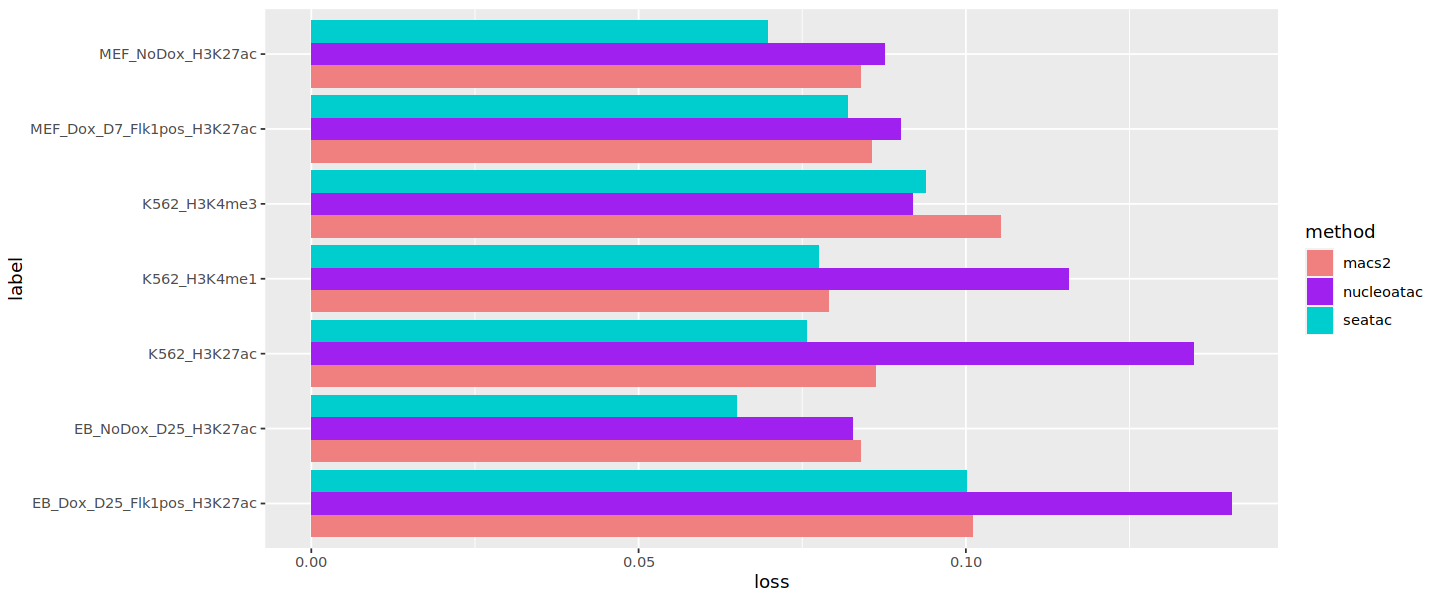

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 5)
df_losses %>%
  mutate(method = factor(method, c('macs2', 'nucleoatac', 'seatac'))) %>%
  mutate(label = sprintf('%s_%s', dataset, type)) %>%

  ggplot(aes(x = label, y = loss, fill = method)) +
    geom_bar(stat = 'identity', position=position_dodge()) +
    scale_fill_manual(values= c(macs2 = 'lightcoral', nucleoatac = 'purple', seatac = 'cyan3')) +
    coord_flip()

In [ ]:
df_losses %>%
  mutate(method = factor(method, c('macs2', 'nucleoatac', 'seatac'))) %>%
  mutate(label = sprintf('%s_%s', dataset, type)) %>%
  group_by(method) %>%
  summarize(loss_mean = mean(loss), loss_std = sd(loss))

method,loss_mean,loss_std
<fct>,<dbl>,<dbl>
macs2,0.08935848,0.009858105
nucleoatac,0.10624094,0.023993544
seatac,0.08060138,0.012655928


In [ ]:
wilcox.test(df_losses$loss[df_losses$method == 'seatac'], df_losses$loss[df_losses$method == 'macs2'], alternative = 'less')


	Welch Two Sample t-test

data:  df_losses$loss[df_losses$method == "seatac"] and df_losses$loss[df_losses$method == "macs2"]
t = -1.4443, df = 11.322, p-value = 0.08788
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
        -Inf 0.002103849
sample estimates:
 mean of x  mean of y 
0.08060138 0.08935848 


In [ ]:
wilcox.test(df_losses$loss[df_losses$method == 'seatac'], df_losses$loss[df_losses$method == 'nucleoatac'], alternative = 'less')


	Wilcoxon rank sum exact test

data:  df_losses$loss[df_losses$method == "seatac"] and df_losses$loss[df_losses$method == "nucleoatac"]
W = 8, p-value = 0.01894
alternative hypothesis: true location shift is less than 0


## Read the raw H3K37ac signal for Etv2 data

In [ ]:
etv2_samples <- c('MEF_NoDox','MEF_Dox_D7_Flk1pos','EB_NoDox_D25','EB_Dox_D25_Flk1pos')

In [ ]:
y <- NULL
for (i in which(names(ARGS$remote_bam_files) %in% etv2_samples)){
  j <- 'H3K27ac'
  sprintf('reading %s', ARGS$local_bw_files[[i]][j]) %>% message()
  cvg <- rtracklayer::import(ARGS$local_bw_files[[i]][j], which = rowRanges(x[[i]]))
  seqlengths(cvg) <- seqlengths(cvg) + ARGS$block_size
  cvg <- coverage(cvg, weight = 'score')
  yi <- cvg[rowRanges(x[[i]])] %>% as.matrix() %>% tf$cast(tf$float32)
  yi <- tf$expand_dims(yi, axis = 1L)
  y <- c(y, yi)
}
y <- tf$concat(y, axis = 1L)

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_NoDox_d0_H3K27ac_FE.bw

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d7_H3K27ac_FE.bw

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_NoDox_12h_H3K27ac_FE.bw

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_Dox_12h_H3K27ac_FE.bw



In [ ]:
y <- y %>% tf$expand_dims(3L)

## Predicting histone signal for Etv2 data

In [ ]:
histones <- c('H3K27ac', 'H3K4me1', 'H3K4me3')

In [ ]:
y_pred <- NULL
for (i in which(names(ARGS$remote_bam_files) %in% etv2_samples)){
  x_test <- tf$cast(rowData(x[[i]])$vae_z_mean[, 1, ], tf$float32)
  yi <- model_histone(x_test) 
  yi <- tf$expand_dims(yi, axis = 1L)
  y_pred <- c(y_pred, yi)
}
y_pred <- tf$concat(y_pred, axis = 1L)

## Read Etv2 data again

In [ ]:
x2 <- read_vplot(
  gr_etv2,
  filenames = ARGS$local_bam_files[etv2_samples],
  genome = get_bsgenome('mm10'),
  bin_size = ARGS$bin_size,
  fragment_size_range = c(0, ARGS$fragment_size_range_max),
  fragment_size_interval = ARGS$fragment_size_interval 
)

read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_NoDox.bam

read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_Flk1pos.bam

read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_NoDox_D25.bam

read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_Dox_D25_Flk1pos.bam



In [ ]:
y <- as.array(y)
dimnames(y)[[4]] <- 'H3K27ac'

In [ ]:
y_pred <- as.array(y_pred)
dimnames(y_pred)[[4]] <- histones

ERROR: ignored

In [ ]:
rowData(x2)$histone <- y
rowData(x2)$histone_pred <- y_pred

In [ ]:
x2

class: Vplots
dim: 32222 4 64 128
assays(1): counts
rowData(3): score histone histone_pred
dimdata:
grange: names(1): id
sample: names(3): id filename name
interval: names(2): id center
bin: names(2): id position
## fragment_size_range:0,640
## fragment_size_interval:10
## bin_size:5
## window_size:640

## Save representations

In [ ]:
dir <- gsub('(.+)/.+', '\\1', ARGS$local_representation_file)
if (!file.exists(dir)) dir.create(dir, recursive = TRUE)
sprintf('writing %s', ARGS$local_representation_file) %>% message()
saveRDS(x2, file = ARGS$local_representation_file)
command <- sprintf('s3cmd sync %s %s',  ARGS$local_representation_file,  ARGS$s3_representation_file)
message(command)
system(command)
command <- sprintf('s3cmd setacl -P %s',  ARGS$s3_representation_file)
message(command)
system(command)
message(ARGS$remote_representation_file)

writing ./s3.msi.umn.edu/gongx030/projects/seatac_project/etv2_20230108a.RData

s3cmd sync ./s3.msi.umn.edu/gongx030/projects/seatac_project/etv2_20230108a.RData s3://gongx030/projects/seatac_project/etv2_20230108a.RData

s3cmd setacl -P s3://gongx030/projects/seatac_project/etv2_20230108a.RData

https://s3.msi.umn.edu/gongx030/projects/seatac_project/etv2_20230108a.RData



## SessionInfo

In [ ]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /panfs/jay/groups/18/garrydj/gongx030/.conda/envs/r421_py37_tf26/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] BSgenome.Hsapiens.UCSC.hg19_1.4.3  BSgenome.Mmusculus.UCSC.mm10_1.4.3
 [3] BSgenome_1.64.0                    rtracklayer_1.56.1                
 [5] Biostrings_2.64.1                  XVector_0.36.0                    
 [7] bpt_0.1.005                 